In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings('ignore')
%matplotlib inline

In [56]:
dataset = pd.read_csv("../../Datasets/spaceship-titanic/train.csv")

dataset.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Get a high-level overview of the data we have here...

In [57]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


Let's check the missing values first. As we can see, dataset contains a lot of missing values almost in each column. The following step will be training a new model which will impute missing values

In [58]:
# Get all the missing values
dataset.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [59]:
# Let's encode the categorical features first

columns_to_impute = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
                     'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

le = LabelEncoder()

# Start here
for col in columns_to_impute:
    dataset[col] = le.fit_transform(dataset[col].astype(str))


In [60]:
# Build a pipline that we will use to impute the missing values
param_grid = {'imputer__knn_imputer__n_neighbors': [3, 5, 7, 9, 11]}

imputer_pipeline = Pipeline([
    ('imputer', ColumnTransformer([
    ('knn_imputer', KNNImputer(), columns_to_impute)
    ], remainder='passthrough'))
])

grid_search = GridSearchCV(imputer_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(dataset, dataset['Transported'])


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('knn_imputer',
                                                                         KNNImputer(),
                                                                         ['HomePlanet',
                                                                          'CryoSleep',
                                                                          'Cabin',
                                                                          'Destination',
                                                                          'Age',
                                                                          'VIP',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck'])]))]),
             param_grid={'imputer__knn_imputer__n_neighbors': [3, 5, 7, 9, 11]},
             scoring='neg_mean_squared_error')

In [61]:
best_params = grid_search.best_params_
print("Best parametes are: {}".format(best_params))

imputer = KNNImputer(n_neighbors=best_params['imputer__knn_imputer__n_neighbors'])

df_imputed = pd.DataFrame(imputer.fit_transform(dataset[columns_to_impute]), columns=columns_to_impute)

Best parametes are: {'imputer__knn_imputer__n_neighbors': 3}


In [62]:
df_imputed = pd.concat([df_imputed, dataset.drop(columns_to_impute, axis=1)], axis=1)
df = df_imputed.copy()

print(df_imputed.head())
print(df_imputed.isnull().sum())

   HomePlanet  CryoSleep   Cabin  Destination   Age  VIP  RoomService  \
0         1.0        0.0   149.0          2.0  33.0  0.0          0.0   
1         0.0        0.0  2184.0          2.0  17.0  0.0         54.0   
2         1.0        0.0     1.0          2.0  54.0  1.0        779.0   
3         1.0        0.0     1.0          2.0  27.0  0.0          0.0   
4         0.0        0.0  2186.0          2.0   8.0  0.0        621.0   

   FoodCourt  ShoppingMall     Spa  VRDeck PassengerId               Name  \
0        0.0           0.0     0.0     0.0     0001_01    Maham Ofracculy   
1     1438.0         435.0   933.0   781.0     0002_01       Juanna Vines   
2      779.0           0.0  1065.0   842.0     0003_01      Altark Susent   
3      142.0         585.0   645.0   362.0     0003_02       Solam Susent   
4     1229.0         202.0   953.0   382.0     0004_01  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         Tru

After we have imputed all the features that can be predicted with the model, I will replace the "Name" column with the new category - "Unknown"

In [63]:
new_category = 'Unknown'

missing_names = df['Name'].isnull()

df.loc[missing_names, 'Name'] = new_category

Before scaling the parameters we have to make sure that the dataset contain only numerical values

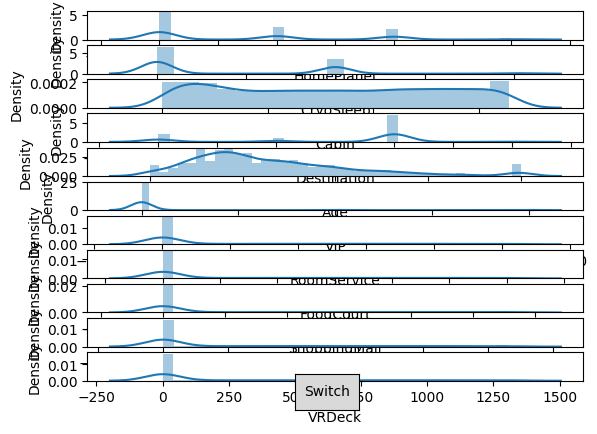

In [64]:
# Plotting the distribution of the features in the dataset
from matplotlib.widgets import Button
numerical_cols = [x for x in df.columns if df[x].dtype != 'object' and df[x].dtype != 'bool']

fig, axs = plt.subplots(len(numerical_cols))

for i, col in enumerate(numerical_cols):
    sns.distplot(df[col], ax = axs[i])

def switch_plot(event):
    current = axs.index(plt.gca())

    plt.clf()

    axs[current].set_visible(False)
    axs[(current + 1) % len(axs)].set_visible(True)

    plt.draw()

button_ax = plt.axes([0.45, 0.05, 0.1, 0.075])
button = Button(button_ax, 'Switch')
button.on_clicked(switch_plot)

plt.show()

